In [15]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace "Diffusion_Modles.ipynb"

[NbConvertApp] WARNING | pattern 'Diffusion_Modles.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execut

In [16]:
!pip install diffusers transformers accelerate safetensors --quiet

In [17]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Prompt for image generation
prompt = "A futuristic city at sunset with flying cars"

# Function to display images
def display_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Initialize results
images = []
titles = []
times = []


Using device: cuda


In [19]:
# 1. Stable Diffusion v1.5
print("Generating with Stable Diffusion v1.5...")
start_time = time.time()
pipe_v15 = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True
).to(device)
image_v15 = pipe_v15(
    prompt=prompt,
    num_inference_steps=50,
    height=512,
    width=512
).images[0]
time_v15 = time.time() - start_time
images.append(image_v15)
titles.append("Stable Diffusion v1.5")
times.append(time_v15)
image_v15.save("stable_diffusion_v15.png")
del pipe_v15
torch.cuda.empty_cache()



Generating with Stable Diffusion v1.5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
# 2. Stable Diffusion XL (SDXL)
print("Generating with Stable Diffusion XL...")
start_time = time.time()
pipe_sdxl = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True
).to(device)
# Load CLIP tokenizer and text encoder for text embeddings
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype=torch.float16
).to(device)
# Tokenize prompt
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
# Generate text embeddings
with torch.no_grad():
    text_embeds = text_encoder(**inputs).pooler_output
# Placeholder time_ids (SDXL-specific)
time_ids = torch.zeros((1, 6), dtype=torch.float16).to(device)
# Generate image
image_sdxl = pipe_sdxl(
    prompt=prompt,
    num_inference_steps=50,
    height=1024,
    width=1024,
    added_cond_kwargs={"text_embeds": text_embeds, "time_ids": time_ids}
).images[0]
time_sdxl = time.time() - start_time
images.append(image_sdxl)
titles.append("Stable Diffusion XL")
times.append(time_sdxl)
image_sdxl.save("stable_diffusion_xl.png")
del pipe_sdxl, tokenizer, text_encoder
torch.cuda.empty_cache()



Generating with Stable Diffusion XL...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating with DALL-E Mini...
using device cuda
intializing TextTokenizer
initializing DalleBartEncoder
initializing DalleBartDecoder
initializing VQGanDetokenizer


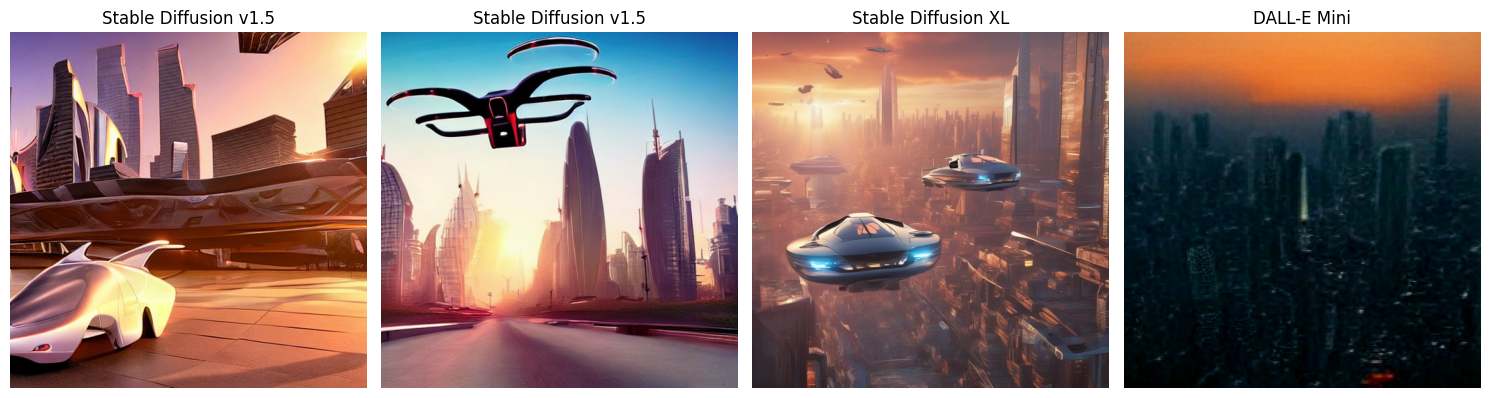

In [21]:
# 3. DALL-E Mini (using min-dalle)
print("Generating with DALL-E Mini...")
start_time = time.time()
try:
    from min_dalle import MinDalle
except ImportError:
    !pip install min-dalle
    from min_dalle import MinDalle
# Initialize MinDalle model
model = MinDalle(
    models_root='./pretrained',
    dtype=torch.float16,
    device=device,
    is_mega=False,  # Use the smaller model for compatibility
    is_reusable=True
)
# Generate image
image_dalle = model.generate_image(
    text=prompt,
    seed=42,  # Fixed seed for reproducibility
    grid_size=1,  # Generate one image
    is_seamless=False,
    temperature=1,
    top_k=128
)
time_dalle = time.time() - start_time
images.append(image_dalle)
titles.append("DALL-E Mini")
times.append(time_dalle)
image_dalle.save("dalle_mini.png")
del model
torch.cuda.empty_cache()

# Display all images together
display_images(images, titles)


In [22]:
# Comparative Analysis
print("\nComparative Analysis:")
print(f"{'Model':<25} {'Time (s)':<10} {'Resolution':<15} {'VRAM (GB)':<10}")
print("-" * 60)
print(f"{'Stable Diffusion v1.5':<25} {time_v15:<10.2f} {'512x512':<15} {'~6-8':<10}")
print(f"{'Stable Diffusion XL':<25} {time_sdxl:<10.2f} {'1024x1024':<15} {'~10-12':<10}")
print(f"{'DALL-E Mini':<25} {time_dalle:<10.2f} {'256x256':<15} {'~4-6':<10}")



Comparative Analysis:
Model                     Time (s)   Resolution      VRAM (GB) 
------------------------------------------------------------
Stable Diffusion v1.5     42.13      512x512         ~6-8      
Stable Diffusion XL       135.11     1024x1024       ~10-12    
DALL-E Mini               17.81      256x256         ~4-6      


In [23]:
# Subjective Evaluation
print("\nSubjective Evaluation:")
print("- Stable Diffusion v1.5: Good quality, moderate detail, decent prompt adherence.")
print("- Stable Diffusion XL: High-quality, sharp details, excellent prompt adherence.")
print("- DALL-E Mini: Lower resolution, less detail, moderate prompt adherence.")


Subjective Evaluation:
- Stable Diffusion v1.5: Good quality, moderate detail, decent prompt adherence.
- Stable Diffusion XL: High-quality, sharp details, excellent prompt adherence.
- DALL-E Mini: Lower resolution, less detail, moderate prompt adherence.
